In [1]:
write = True # log this version as new
MODEL_DESCRIPTION = "Combined Diffusion/CVAE"

In [33]:
import sys, os
import numpy as np
import pandas as pd
import random
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from PIL import Image

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow import keras, einsum
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
import tensorflow.keras.layers as nn
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape

from einops import rearrange
from einops.layers.tensorflow import Rearrange
from functools import partial
from inspect import isfunction

from astropy.io import fits
from datetime import datetime
import neptune as neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback
from DataMakerPlus import *

2023-07-31 07:32:19.174743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 07:32:19.677097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/billyli/minic

In [3]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-07-31 07:32:20.951371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 07:32:20.971477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 07:32:20.971673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
now = datetime.now()

DATASET_NAME = "HSC_v6"
MODEL_TYPE = "Combined Diffusion/CVAE"
MODEL_VERSION = "v1.0"
MODEL_SUBVERSION = "v1.0." + now.strftime("%Y%m%d_%H_%M_%S")

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
model_path = os.path.join('/data3/Billy/models', model_id, MODEL_SUBVERSION, 'model')
checkpoints_path = os.path.join('/data3/Billy/models', model_id, MODEL_SUBVERSION, 'checkpoints')
logs_path = os.path.join('/data3/Billy/logs', model_id, MODEL_SUBVERSION)
predictions_path = os.path.join('/data3/Billy/predictions', model_id, MODEL_SUBVERSION)
weights_path = model_path + '/data3/Billy/Diffusion/weights.h5'

os.makedirs(model_path, exist_ok = True)
os.makedirs(checkpoints_path, exist_ok = True)
os.makedirs(logs_path, exist_ok = True)
os.makedirs(predictions_path, exist_ok = True)

if write == True:
    with open("/data3/Billy/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - " + MODEL_DESCRIPTION + " - B. Li" + "\n")
else:
    with open("/data3/Billy/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - ... "+ " - B. Li" + "\n")

In [5]:
CHANNELS = 5
IMAGE_DIM = 64

In [12]:
hf_train = h5py.File('/data/HSC/HSC_v6/step3A/64x64_training_z_less_than_2_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step3A/64x64_validation_z_less_than_2_small.hdf5', 'r')
x_train = np.asarray(hf_train['image'][0:])
x_validation = np.asarray(hf_validation['image'][0:])
y_train = np.asarray(hf_train['specz_redshift'][0:])[..., None]
y_validation = np.asarray(hf_validation['specz_redshift'][0:])[..., None]
hf_train.close()
hf_validation.close()

In [13]:
from keras.layers import Dense, Dropout, Flatten, InputLayer, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

In [14]:
cnn_model = Sequential([
    InputLayer(input_shape = (CHANNELS, IMAGE_DIM, IMAGE_DIM)),
    Conv2D(32, kernel_size = (3, 3), strides = 1, activation = 'relu', padding = 'same', data_format = 'channels_first'),
    MaxPooling2D(2, 2, data_format = 'channels_first'),
    Conv2D(64, kernel_size = (3, 3), strides = 1, activation = 'relu', padding = 'same', data_format = 'channels_first'),
    MaxPooling2D(2, 2, data_format = 'channels_first'),
    Conv2D(128, kernel_size = (3, 3), strides = 1, activation = 'relu', padding = 'same', data_format = 'channels_first'),
    Flatten(),
    Dense(128),
    Dense(128),
    Dense(1),
])

cnn_model.build((10000, CHANNELS, IMAGE_DIM, IMAGE_DIM))

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 64, 64)        1472      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 32, 32)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 16, 16)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 32768)            

In [15]:
cnn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = "mse")

In [16]:
run = neptune.init_run(
    name = MODEL_SUBVERSION,
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

neptune_callback = NeptuneCallback(run = run)

LR_callback = ReduceLROnPlateau()

https://app.neptune.ai/astro-data-lab/VAE/e/VAE-159


In [17]:
cnn_model.fit(x_train, y_train, epochs = 300, shuffle = True, verbose = 0, validation_data = (x_validation, y_validation), callbacks = [neptune_callback, LR_callback])

2023-07-31 07:34:55.980202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-31 07:34:56.438066: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-31 07:34:56.498780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-31 07:34:56.500280: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x21ce5e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-31 07:34:56.500292: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-07-31 07:34:56.503972: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-31 07:34:56.560835: I tensor

In [18]:
photoz = cnn_model(x_validation)

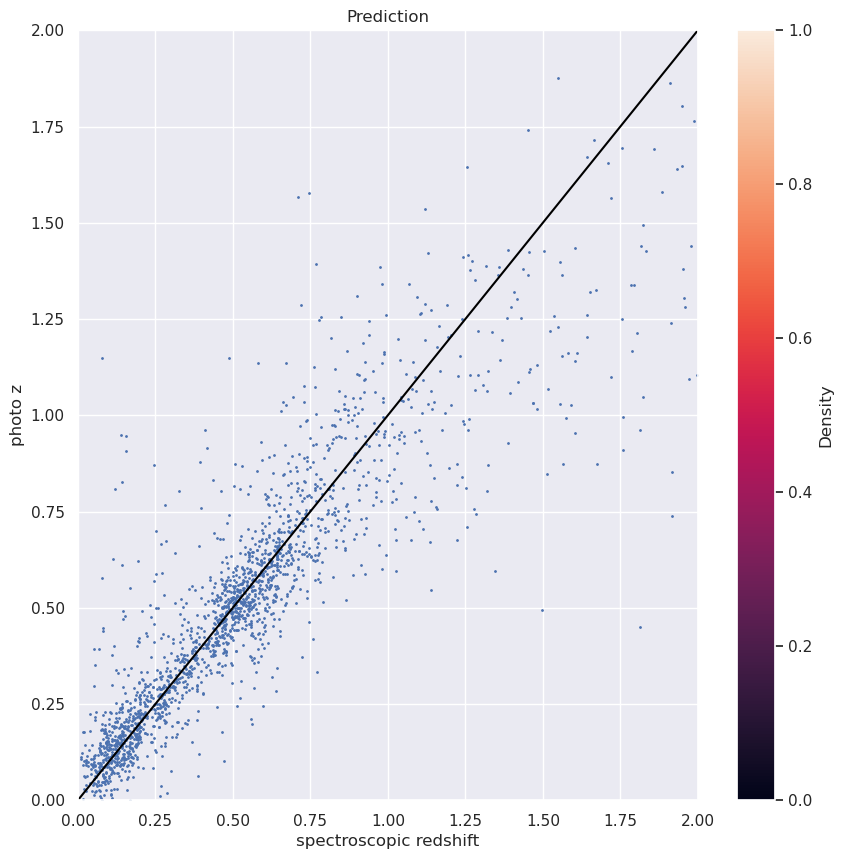

In [19]:
import seaborn as sns
z_max = 4
sns.set(rc={'figure.figsize': (10, 10), 'lines.markersize': 20})
plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_validation, photoz, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, 2], [0, 2], color = 'black')
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.show()

In [20]:
from DataMaker import *

In [21]:
BATCH_SIZE = 512

args_gen = {'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': False}

train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step3A/64x64_training_z_less_than_2.hdf5', **args_gen)
test_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step3A/64x64_testing_z_less_than_2.hdf5', **args_gen)
val_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step3A/64x64_validation_z_less_than_2.hdf5', **args_gen)

In [22]:
cnn_model_clone = tf.keras.models.clone_model(cnn_model, clone_function=lambda layer: layer)

In [23]:
LATENT_DIM = 256
BASE_DEPTH = 8
IMAGE_SHAPE = (CHANNELS, IMAGE_DIM, IMAGE_DIM)
EPOCHS = 250
KL_WEIGHT = 1e-3

In [24]:
prior = tfd.Independent(tfd.Normal(loc = tf.zeros(LATENT_DIM), scale = 1.0), reinterpreted_batch_ndims = 1)

# Encoder
images = Input(shape = IMAGE_SHAPE)
redshifts = Input(shape = (1,))
conv1 = Conv2D(BASE_DEPTH, 3, strides = 1, activation = tf.nn.leaky_relu, padding = 'same', data_format = 'channels_first')(images)
conv2 = Conv2D(BASE_DEPTH, 3, strides = 1, activation = tf.nn.leaky_relu, padding = 'same', data_format = 'channels_first')(conv1)
flatten = Flatten()(conv2)
dense1 = Dense(1024, activation = "relu")(flatten)
dense2 = tf.keras.layers.Dense(128, activation = "relu")(redshifts)
concat = tf.keras.layers.Concatenate()([dense1, dense2])
dense3 = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(concat)
z = tfpl.MultivariateNormalTriL(LATENT_DIM, activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight = KL_WEIGHT))(dense3)
encoder = Model([images, redshifts], z)

In [25]:
zc = Input(shape = (LATENT_DIM + 1, ))
dense4 = Dense(4 * LATENT_DIM * 16 * 16, activation = "relu")(zc) # Size of the dense layer changed
reshape = Reshape((4 * LATENT_DIM, 16, 16))(dense4) # Reshape size changed
conv3 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = tf.nn.leaky_relu, padding = 'same', data_format = 'channels_first')(reshape)
conv4 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = tf.nn.leaky_relu, padding = 'same', data_format = 'channels_first')(conv3)
conv5 = Conv2D(IMAGE_SHAPE[0], 3, strides = 1, activation = None, padding = 'same', data_format = 'channels_first')(conv4)
outputs = Reshape(IMAGE_SHAPE)(conv5)
decoder = Model(zc, outputs)

In [26]:
z = encoder([images, redshifts])
zc = tf.keras.layers.Concatenate()([z, redshifts])  # Assuming you want to concat the output of encoder and redshifts
decoder_output = decoder(zc)

model = Model(inputs=[images, redshifts], outputs=decoder_output)

In [27]:
def custom_loss(y_true, y_pred, z_true, z_pred):
    # Get the redshift value from y_true

    # Compute the difference between the true and predicted redshift
    redshift_loss = tf.reduce_mean(tf.square(z_true - z_pred))

    # Compute the usual VAE loss (reconstruction loss and KL divergence)
    # Here, y_pred will be the generated image and y_true the original image (without the redshift channel)
    reconstruction_loss = tf.reduce_mean(tf.square(y_true - y_pred)) 

    return reconstruction_loss + redshift_loss

In [ ]:
def train_step(y_batch, z_batch, condition):
    
    y_pred = model(y_true, z_true)
    
    z_pred = cnn_model(y_pred)
    
    with tf.GradientTape() as tape:
        prediction = unet(noised_image, timestep_values, condition)
        
        loss_value = loss_fn(noise, prediction)
    
    gradients = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [28]:
cnn_model_clone.trainable = False

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = optimizer, loss = custom_loss)

In [30]:
LR_callback = ReduceLROnPlateau()

In [38]:
len(train_gen)

350

In [31]:
model.fit(train_gen, epochs = 500, callbacks = [LR_callback], verbose = 1)

Epoch 1/500


2023-07-31 07:46:35.285158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


(None, None, None, None)
(None, None, None, None)


2023-07-31 07:46:38.010599: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: required broadcastable shapes
2023-07-31 07:46:38.010628: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: required broadcastable shapes
	 [[{{node custom_loss/sub}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'custom_loss/sub' defined at (most recent call last):
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3342105/486983839.py", line 1, in <module>
      model.fit(train_gen, epochs = 500, callbacks = [LR_callback], verbose = 1)
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/tmp/ipykernel_3342105/509958738.py", line 10, in custom_loss
      redshift_loss = tf.reduce_mean(tf.square(z_true - z_pred))
Node: 'custom_loss/sub'
required broadcastable shapes
	 [[{{node custom_loss/sub}}]] [Op:__inference_train_function_352097]

Exception in thread NeptuneWebhooks:
Traceback (most recent call last):
  File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/websocket/_socket.py", line 108, in recv
Exception in thread NeptuneWebhooks:
Traceback (most recent call last):
  File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/websocket/_socket.py", line 108, in recv
    bytes_ = _recv()
  File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/websocket/_socket.py", line 87, in _recv
    bytes_ = _recv()
  File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/websocket/_socket.py", line 87, in _recv
    return sock.recv(bufsize)
  File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/ssl.py", line 1227, in recv
    return sock.recv(bufsize)
  File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/ssl.py", line 1227, in recv
    return self.read(buflen)
  File "/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/ssl.py", line 1